<div style="display: flex; align-items: center; gap: 30px; padding-bottom: 10px;">
    <img src="fig/logo/logo_fwc.png" alt="Logo" style="width: 150px">
    <div>
        <h1 style="margin: 0; font-size: 2.0em;">TFM - Inteligencia Artificial para la Observación de la Tierra: Comparación de modelos para la Monitorización de la vegetación</h1>
        <h1></h1>
        <h2 style="margin: 5px 0 0 0; color: #555; font-size: 1.5em;">Adolfo Molada Tebar</h2>
    </div>
</div>

## SUPPORT VECTOR MACHINE

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC

import display_functions
import helper_functions
import model_functions

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Preparar el entorno de trabajo

In [3]:
current_dir = os.getcwd()

project_dir = os.path.join(current_dir, "fwc")
project_data = os.path.join(project_dir, "data")

project_data_training = os.path.join(project_data, "training")
project_models = os.path.join(project_dir,"models")

### Cargar los datos

Nota: Estoy entrenando con todos los datos, no con los que he eliminado los outliers

In [4]:
feather_file_path = os.path.join(project_data_training, "data.feather")
data = pd.read_feather(feather_file_path)

In [5]:
data.describe()

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
count,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,...,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000,567.000000
mean,15466.359788,0.433862,0.328589,0.349635,0.318131,0.354350,0.157438,0.357195,36.823065,-3.634057,...,0.098274,0.038967,18.770834,0.081939,0.043530,2.626863,0.342886,1.098454,1.086219,1.007287
std,7144.236501,0.608058,0.139269,0.127110,0.099329,0.159418,0.081765,0.130633,13.412162,2.665701,...,0.137972,0.025428,0.013241,0.052172,0.054708,2.116683,0.126894,0.132174,0.115080,0.191885
min,1.000000,0.000000,0.047059,0.086275,0.101961,0.061111,0.016129,0.101961,7.438742,-14.478152,...,-0.153846,-0.053763,18.717208,-0.102035,-0.098182,-2.450980,0.087484,0.821191,0.782604,0.437497
25%,6746.500000,0.000000,0.223529,0.258824,0.250980,0.212121,0.100893,0.260784,27.078731,-5.235742,...,0.021016,0.024955,18.763414,0.052272,0.011494,1.392157,0.250305,1.023251,1.012119,0.880594
50%,17646.000000,0.000000,0.309804,0.341176,0.317647,0.370370,0.137615,0.341176,35.882136,-3.757126,...,0.081967,0.038835,18.771643,0.080373,0.042105,2.333333,0.330585,1.087909,1.077919,0.977270
75%,17798.500000,1.000000,0.401961,0.419608,0.376471,0.484848,0.202290,0.423529,44.579033,-2.167105,...,0.155050,0.052012,18.778433,0.110365,0.073529,3.588235,0.413051,1.158725,1.141356,1.090591
max,29255.000000,2.000000,0.792157,0.835294,0.764706,0.888889,0.562500,0.835294,83.894231,6.945201,...,1.363605,0.152000,18.812741,0.358478,0.358489,11.352941,0.819611,2.117615,1.607835,1.737494


In [6]:
data.sample(5)

,sample_id,label,R,G,B,H,S,V,L,a,...,vari,gli,cive,rgbvi,ngrdi,tgi,L_perc,gr,gb,rb
371,17866,1,0.403922,0.427451,0.392157,0.277778,0.082569,0.427451,45.277257,-4.142508,...,0.053571,0.035629,18.769447,0.071277,0.028302,2.941176,0.419900,1.058250,1.089997,1.029997
157,6669,0,0.470588,0.470588,0.454902,0.166667,0.033333,0.470588,50.318989,-0.793928,...,0.000000,0.008403,18.788020,0.016949,0.000000,0.941176,0.469456,0.999998,1.034480,1.034480
473,27492,1,0.505882,0.439216,0.345098,0.097561,0.317829,0.505882,48.210425,2.767159,...,-0.111111,0.015873,18.786753,0.049883,-0.070539,3.313725,0.446594,0.868215,1.272724,1.465905
383,6621,1,0.278431,0.317647,0.313725,0.483333,0.123457,0.317647,33.570272,-4.196738,...,0.138888,0.035144,18.772961,0.071971,0.065789,1.607843,0.309027,1.140841,1.012497,0.887497
540,17568,0,0.239216,0.282353,0.270588,0.454545,0.152778,0.282353,29.554284,-5.144989,...,0.171874,0.051095,18.767682,0.103800,0.082707,2.215686,0.272333,1.180323,1.043474,0.884055


### Datos

In [7]:
X = data.iloc[:, 2:] # variables / features
y = data.iloc[:, 1]  # etiquetas

print(X.shape)
print(y.shape)

(567, 26)
(567,)


### Hold-out externo

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#, stratify=y)

#### Estandarización de los datos de entrenamiento

En SVC es necesario estandarizar los datos porque el algoritmo se apoya en productos escalares y distancias entre muestras, especialmente cuando se emplean kernels no lineales como RBF. Si las variables están en escalas diferentes, las de mayor magnitud dominan el cálculo de distancias, relegando a las demás aunque sean informativamente relevantes. Esto distorsiona la geometría del margen, hace que el parámetro de regularización _C_ pierda una interpretación homogénea y afecta directamente al parámetro _gamma_, cuyo efecto depende de la escala de los datos. Como resultado, el modelo puede aprender fronteras sesgadas y ser muy sensible a las unidades de medida. La estandarización asegura que todas las variables contribuyan de forma comparable y que los hiperparámetros tengan un significado coherente, mejorando la estabilidad y la capacidad de generalización del modelo.

In [9]:
standardizer = StandardScaler()
X_train_std = standardizer.fit_transform(X_train)
X_test_std = standardizer.transform(X_test)  # Solo transform, no fit

### Construcción del modelo

Con parámetros fijos iniciales

In [10]:
svm = SVC(class_weight="balanced",
          random_state=42, 
          probability=True, # Coste computacional mayor (usa validación interna tipo Platt scaling).
          decision_function_shape="ovr") # suele ser más rápido para multiclase

Hiperparámetros

In [11]:
param_grid = {"C": [0.1, 1, 10, 100], # C pequeño → margen amplio, más errores → modelo simple
                                      # C grande → menos errores, margen estrecho → riesgo de overfitting
              "kernel": ["linear", "rbf", "poly"],# no sigmoid -> incluirlos todos aumenta la complejidad sin mejorar normalmente el rendimiento
              "degree": [2,3,4], # solo para poly
              "gamma": [1e-3, 1e-2, 1e-1, 1] # pequeño → influencia lejana → frontera suave; 
                                             # grande → influencia local → frontera muy compleja
              }

Entrenamiento: GridSearchCV -> selección de hiperparámetros

StratifiedKFold -> hold-out interno

StratifiedKFold vs KFold


La validación cruzada mediante _KFold_ divide el conjunto de datos en  particiones de manera estrictamente aleatoria o secuencial sin considerar la distribución de la variable objetivo, lo cual puede derivar en subconjuntos que no reflejen la realidad de la población, particularmente en escenarios de clases desbalanceadas donde la clase minoritaria podría quedar excluida de ciertos pliegues. En contraste, _StratifiedKFold_ mitiga este sesgo al implementar un muestreo estratificado que preserva la proporción relativa de cada clase en todos los subconjuntos generados, garantizando así la representatividad estadística del dataset original en cada iteración; esta característica convierte a la variante estratificada en la aproximación metodológica superior para problemas de clasificación, pues asegura la estabilidad y fiabilidad de las métricas de evaluación independientemente del desequilibrio de las clases.

In [12]:
cv_svm = GridSearchCV(
    svm, 
    param_grid, 
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), 
    scoring="f1_macro", # Todas las clases pesan igual #'accuracy' -> no si están desbalanceadas 
    return_train_score=True,
    n_jobs=-1
)

Entrenamiento

In [13]:
cv_svm.fit(X_train_std, y_train)

,estimator,SVC(class_wei...ndom_state=42)
,param_grid,"{'C': [0.1, 1, ...], 'degree': [2, 3, ...], 'gamma': [0.001, 0.01, ...], 'kernel': ['linear', 'rbf', ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,C,10


Resultados de la búsqueda de parámetros

In [14]:
results = pd.DataFrame(cv_svm.cv_results_)
print(results[["params", "mean_test_score", "std_test_score"]]) # Mostramos solo columnas útiles

                                                params  mean_test_score  \
0    {'C': 0.1, 'degree': 2, 'gamma': 0.001, 'kerne...         0.720794   
1    {'C': 0.1, 'degree': 2, 'gamma': 0.001, 'kerne...         0.684979   
2    {'C': 0.1, 'degree': 2, 'gamma': 0.001, 'kerne...         0.131500   
3    {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel...         0.720794   
4    {'C': 0.1, 'degree': 2, 'gamma': 0.01, 'kernel...         0.742243   
..                                                 ...              ...   
139  {'C': 100, 'degree': 4, 'gamma': 0.1, 'kernel'...         0.773324   
140  {'C': 100, 'degree': 4, 'gamma': 0.1, 'kernel'...         0.748142   
141  {'C': 100, 'degree': 4, 'gamma': 1, 'kernel': ...         0.786214   
142  {'C': 100, 'degree': 4, 'gamma': 1, 'kernel': ...         0.586656   
143  {'C': 100, 'degree': 4, 'gamma': 1, 'kernel': ...         0.746693   

     std_test_score  
0          0.065305  
1          0.078752  
2          0.095216  
3          

### Métricas

Mejor modelo

In [15]:
svm_best_model = cv_svm.best_estimator_
print("Mejor hiperparámetros: ", cv_svm.best_params_)

Mejor hiperparámetros:  {'C': 10, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}


Predicción

In [16]:
y_pred = svm_best_model.predict(X_test_std)  # usando el conjunto de test

Evaluación del mejor modelo con el conjunto test

In [17]:
mse, rmse, r2 = model_functions.compute_metrics(y_test,y_pred)

print("MSE:  ", mse)
print("RMSE: ", rmse)
print("R²:   ", r2)

report = model_functions.compute_classification_report(y_test, y_pred) # Reporte detallado por clase
print(report)
conf_matrix = model_functions.compute_confusion_matrix(y_test, y_pred) # Matriz de confusión
print(conf_matrix)

MSE:   0.21052631578947367
RMSE:  0.45883146774112354
R²:    0.4256926952141058
              precision    recall  f1-score   support

           0       0.93      0.85      0.89        73
           1       0.67      0.82      0.74        34
           2       0.60      0.43      0.50         7

    accuracy                           0.82       114
   macro avg       0.73      0.70      0.71       114
weighted avg       0.83      0.82      0.82       114

[[62 11  0]
 [ 4 28  2]
 [ 1  3  3]]


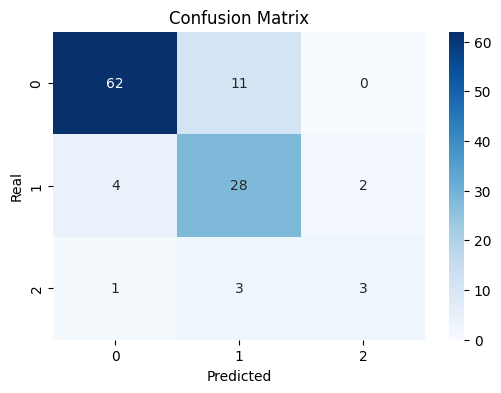

In [18]:
display_functions.plot_confusion_matrix(conf_matrix)

### Ploteamos la curva ROC

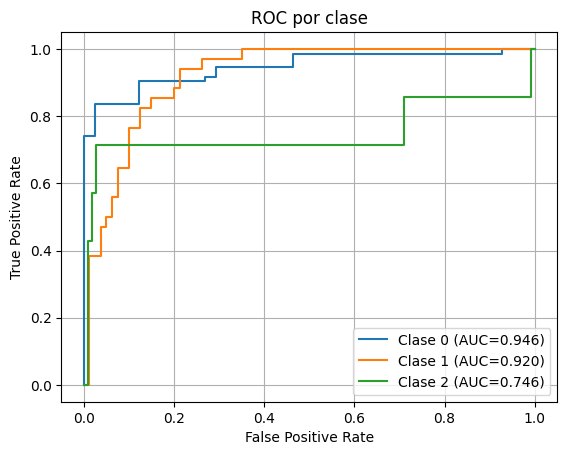

In [19]:
display_functions.plot_roc_curve(svm_best_model,X_test_std, y_test)

## Save SVM best model

In [20]:
svm_best_model_path = os.path.join(project_models, "svm_best_model.pkl")

model_functions.save_model(svm_best_model, svm_best_model_path)

Es necesario guardar el estandarizador para predecir y generar las mascaras

In [21]:

svm_best_model_standarized_path = os.path.join(project_models, "svm_best_model_standarized.pkl")

model_functions.save_model_data_standardizer(standardizer, svm_best_model_standarized_path)